In [69]:
import numpy as np
import torch.nn.functional as F
import torch
import torch.nn as nn
from torchsummary import summary
import matplotlib.pyplot as plt

import os
import sys 
from os.path import dirname as up
sys.path.insert(0, up(up(up(os.path.abspath(__file__)))))
from datasets.datasets import RobotNavDataset

plt.rcParams['figure.figsize'] = [10, 5]

NameError: name '__file__' is not defined

In [2]:
# for now just generate some random data, don't have access to kaggle at work
CLASSES = ['fine_concrete', 'concrete', 'soft_tiles', 'tiled', 'soft_pvc',
           'hard_tiles_large_space', 'carpet', 'hard_tiles', 'wood']
y_train = np.random.choice(CLASSES, size=(3810,), replace=True)
x_train = np.random.rand(3810,10,128)

In [3]:
class ShallowCNN(nn.Module):
    def __init__(self):
        super(ShallowCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=40, kernel_size=(1,10))
        self.conv2 = nn.Conv2d(in_channels=40, out_channels=40, kernel_size=(10,1))
        self.conv2_bn = nn.BatchNorm2d(40)
        self.max_pool = nn.MaxPool2d(kernel_size=(1,25), stride=(1,5))
        self.linear = nn.Linear(in_features=40*19, out_features=10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = F.elu(self.conv2_bn(x))
        x = x.view((-1,40,119))
        x = self.max_pool(x)
        x = x.view((x.size(0), -1))
        x = self.linear(x)
        return x

In [ ]:
'''
class ShallowCNN(nn.Module):
    def __init__(self, n_conv_channels=40, 
                 n_signal_channels=10, 
                 pool_size=25, 
                 pool_stride=15,
                 n_out=10):
        
        super(ShallowCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, 
                               out_channels=n_conv_channels, 
                               kernel_size=(1,n_signal_channels))
        
        self.conv2 = nn.Conv2d(in_channels=n_conv_channels, 
                               out_channels=n_conv_channels, 
                               kernel_size=(n_signal_channels,1))
        
        self.conv2_bn = nn.BatchNorm2d(n_signal_channels)
        
        self.max_pool = nn.MaxPool2d(kernel_size=(1,pool_size), stride=(1,pool_stride))
        # Need to determine how to calculate 7
        self.linear = nn.Linear(in_features=40*7, out_features=n_out)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = F.elu(self.conv2_bn(x))
        # need to determine how to calculate this size
        x = x.view((-1,40,119))
        x = self.max_pool(x)
        x = x.view((x.size(0), -1))
        x = self.linear(x)
        return x
'''

In [5]:
foo = ShallowCNN()
# foo.cuda()

In [6]:
summary(foo, input_size=x_train[0:1].shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 40, 10, 119]             440
            Conv2d-2           [-1, 40, 1, 119]          16,040
       BatchNorm2d-3           [-1, 40, 1, 119]              80
         MaxPool2d-4               [-1, 40, 19]               0
            Linear-5                   [-1, 10]           7,610
Total params: 24,170
Trainable params: 24,170
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.44
Params size (MB): 0.09
Estimated Total Size (MB): 0.54
----------------------------------------------------------------


In [ ]:
def get_data_loader(batchsize, file_dir)

In [82]:
import torchvision.datasets as datasets

In [83]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

Processing...
Done!


In [86]:
mnist_trainset.train_labels.shape

torch.Size([60000])

In [62]:
import pandas as pd
import torch
import numpy as np 
from os.path import join
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, scale
from functools import partial



X_TRAIN = 'X_train.csv'
X_TEST = 'X_test.csv'
Y_TRAIN = 'y_train.csv'

FEATURE_COLS = ['orientation_X',
                'orientation_Y', 'orientation_Z', 'orientation_W', 'angular_velocity_X',
                'angular_velocity_Y', 'angular_velocity_Z', 'linear_acceleration_X',
                'linear_acceleration_Y', 'linear_acceleration_Z']


def x_to_array(df, feature_cols=FEATURE_COLS):
    # Convert tabular data into 3D numpy array
    n_series = len(df.series_id.unique())
    n_features = len(feature_cols)
    n_samples = max(df.measurement_number+1)
    x_trans = np.empty((n_series, n_features, n_samples))
    for i, idee in enumerate(df.series_id.unique()):
        x_trans[i] = np.array(df[df.series_id == idee][feature_cols]).T
    return x_trans
    

def load_and_format_data(path):
    x_train = pd.read_csv(join(path,X_TRAIN))
    x_test = pd.read_csv(join(path,X_TEST))
    y_train = pd.read_csv(join(path,Y_TRAIN))

    x_test = x_to_array(x_test)
    x_train = x_to_array(x_train)
    y_train = y_train.surface # for now just return unencoded values, let Tensorflow take care of this

    return x_train, y_train, x_test


class RobotNavDataset(Dataset):
    # TODO add transformations here
    # TODO add option to one hot labels
    def __init__(self, path_dir, normalize=True):
        self.normalize = normalize
        self.train, self.labels, self.test = self.load_and_format_data(path_dir)
        
    def load_and_format_data(self, path):
        x_train = pd.read_csv(join(path,X_TRAIN))
        x_test = pd.read_csv(join(path,X_TEST))
        y_train = pd.read_csv(join(path,Y_TRAIN))

        x_test = x_to_array(x_test)
        x_train = x_to_array(x_train)
        
        if self.normalize:
            scale_trans = partial(scale, axis=1) # Find better way to do this
            x_train = np.array([scale_trans(samp) for samp in x_train])
            x_test = np.array([scale_trans(samp) for samp in x_test])
        
        y_train = y_train.surface # for now just return unencoded values, let Tensorflow take care of this
        y_train = LabelEncoder().fit_transform(y_train)

        return torch.tensor(x_train), torch.tensor(y_train), torch.tensor(x_test)
        

In [63]:
data = RobotNavDataset('../../data/')


In [64]:
data.train.shape

torch.Size([3810, 10, 128])

In [67]:
samp = data.train[5]

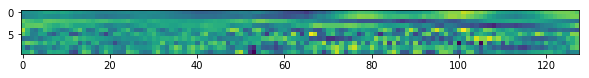

In [68]:
plt.imshow(samp.numpy())

In [46]:
foo = samp.numpy()

In [47]:
bar = scale(foo, axis=1)

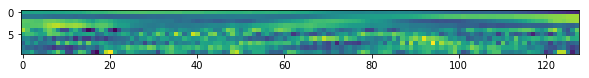

In [48]:
plt.imshow(bar)

In [39]:
bar[9,:]

tensor([-0.0919, -0.0887, -0.0822, -0.0951, -0.0983, -0.0980, -0.0888, -0.0811,
        -0.0720, -0.0830, -0.1056, -0.1062, -0.0885, -0.0744, -0.0769, -0.0914,
        -0.1114, -0.1179, -0.0901, -0.0644, -0.0590, -0.0815, -0.0913, -0.0924,
        -0.0809, -0.0814, -0.0866, -0.0894, -0.0896, -0.0917, -0.0926, -0.1052,
        -0.0876, -0.0782, -0.0752, -0.0811, -0.0818, -0.0829, -0.0914, -0.1000,
        -0.0902, -0.0956, -0.0960, -0.0808, -0.0862, -0.0877, -0.0970, -0.0930,
        -0.0683, -0.0641, -0.0784, -0.0936, -0.0909, -0.0818, -0.0818, -0.0825,
        -0.0919, -0.0993, -0.0988, -0.0999, -0.0878, -0.0742, -0.0752, -0.0835,
        -0.0896, -0.0923, -0.0921, -0.0888, -0.0866, -0.0942, -0.0993, -0.0913,
        -0.0921, -0.0995, -0.0934, -0.0918, -0.0946, -0.0789, -0.0710, -0.0756,
        -0.0891, -0.0883, -0.0805, -0.0773, -0.0785, -0.0920, -0.0993, -0.0995,
        -0.0914, -0.0840, -0.0888, -0.0839, -0.0803, -0.0781, -0.0857, -0.0897,
        -0.0875, -0.0874, -0.0778, -0.07

In [41]:
bar.shape

torch.Size([10, 128])